In [1]:
import azureml.core
print("SDK Version:", azureml.core.VERSION)

SDK Version: 1.26.0


# 1) `ESML - TRAIN Classification, TITANIC model, and DEPLOY with predict_proba scoring

######  NB! This,InteractiveLoginAuthentication, is only needed to run 1st time, then when ws_config is written, use later CELL in notebook, that just reads that file
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication
#sys.path.append(os.path.abspath("../azure-enterprise-scale-ml/esml/common/"))  # NOQA: E402
from esml import ESMLDataset, ESMLProject

p = ESMLProject()
#p.dev_test_prod="dev"
auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)
######  NB!

In [1]:
unregister_all_datasets=True

In [2]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
import pandas as pd 
from esml import ESMLDataset, ESMLProject

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.inference_mode = False # We want "TRAIN" mode
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace

if(unregister_all_datasets):
    p.unregister_all_datasets(p.ws) # For DEMO purpose
    

Using GEN2 as Datastore
Unregister Azure ML dataset for ESML dataset ds01_titanic
- IN name: M01_ds01_titanic_train_IN
- Bronze name: M01_ds01_titanic_train_BRONZE
- Silver name: M01_ds01_titanic_train_SILVER
Gold name: M01_GOLD 
Unregister Azure ML dataset for ESML dataset ds01_titanic
- IN name: M01_ds01_titanic_inference_IN
- Bronze name: M01_ds01_titanic_inference_BRONZE
- Silver name: M01_ds01_titanic_inference_SILVER
Gold name: M01_GOLD 


In [3]:
p.describe()

Inference version: 1

 - ds01_titanic
projects/project002/01_titanic_model_clas/train/ds01_titanic/in/dev/2021/01/01/
projects/project002/01_titanic_model_clas/train/ds01_titanic/out/bronze/dev/
projects/project002/01_titanic_model_clas/train/ds01_titanic/out/silver/dev/
projects/project002/01_titanic_model_clas/inference/1/ds01_titanic/in/dev/2021/01/01/
 

Training GOLD (p.GoldPath)
projects/project002/01_titanic_model_clas/train/gold/dev/
 

[A) USAGE]: to_score_folder, scored_folder, date_folder = p.get_gold_scored_unique_path()
A)INFERENCE ONLINE: GOLD to score (example if realtime - today)
projects/project002/01_titanic_model_clas/inference/1/gold/dev/2021_06_16/257c513d956f4040af6e15f4d924821e/
 

A)INFERENCE ONLINE: GOLD scored (example if realtime today)
projects/project002/01_titanic_model_clas/inference/1/scored/dev/2021_06_16/257c513d956f4040af6e15f4d924821e/
 

[B) USAGE]: to_score_folder_batch, scored_folder, date_folder = p.get_gold_scored_unique_path(p.date_scoring_fold

In [4]:
datastore = p.init() # 3) Automapping from datalake to Azure ML datasets

...
Using GEN2 as Datastore
Searching for setting in ESML datalake...
ESML in-folder settings override = FALSE. [active_in_folder.json,active_scoring_in_folder.json] not found. 
 - Using [active_in_folder.json,active_scoring_in_folder.json] from ArgParse or GIT. No override from datalake settings
ScriptExecutionException was caused by StreamAccessException.
  StreamAccessException was caused by NotFoundException.
    'AdlsGen2-ListFiles (req=1, existingItems=0)' for 'https://msftweudevcmnai2.dfs.core.windows.net/lake3?directory=projects/project002/01_titanic_model_clas/train/active&recursive=true&resource=filesystem' on storage failed with status code 'NotFound' (The specified path does not exist.), client request ID '7e28a83b-080e-4377-88aa-f08d69eb195b', request ID '496445bc-a01f-003e-14f3-62f7af000000'. Error message: {"error":{"code":"PathNotFound","message":"The specified path does not exist.\nRequestId:496445bc-a01f-003e-14f3-62f7af000000\nTime:2021-06-16T21:07:15.8662242Z"}}
| s

In [5]:
p.inference_mode

False

In [6]:
esml_dataset = p.DatasetByName("ds01_titanic") 
df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
p.save_silver(esml_dataset,df_bronze) #Bronze -> Silver

df_silver = esml_dataset.Silver.to_pandas_dataframe() 
gold_train = p.save_gold(df_silver)  #Silver -> Gold

## SUMMARY - step 1
- ESML has now `Automap` and `Autoregister` Azure ML Datasets as: `IN, SILVER, BRONZE, GOLD`
- ESML has read configuration for correct environment (DEV, TEST, PROD). 
    - Both small customers, and large Enterprise customers often wants:  DEV, TEST, PROD in `diffferent Azure ML workspaces` (and different subscriptions)
- User has done feature engineering, and saved GOLD `p.save_gold`

In [7]:
gold_train.to_pandas_dataframe().head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [8]:
label = "Survived"
train_6, validate_set_2, test_set_2 = p.split_gold_3(0.6,label) # Auto-registerin AZURE (M03_GOLD_TRAIN | M03_GOLD_VALIDATE | M03_GOLD_TEST)   

# 2) `ESML` Train model in `5 codelines`

In [8]:
from esml import ESMLDataset, ESMLProject
from baselayer_azure_ml import AutoMLFactory,azure_metric_regression,azure_metric_classification
from azureml.train.automl import AutoMLConfig

automl_performance_config = p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)
aml_compute = p.get_training_aml_compute(ws) # 2)Get compute, for active environment

label = "Survived"
train_6, validate_set_2, test_set_2 = p.split_gold_3(0.6,label) # 3) Auto-registerin AZURE (M03_GOLD_TRAIN | M03_GOLD_VALIDATE | M03_GOLD_TEST)          # Alt: p.Gold.random_split(percentage=0.8, seed=23)

automl_config = AutoMLConfig(task = 'classification', # 4) Override the ENV config, for model(that inhertits from enterprise DEV_TEST_PROD config baseline)
                            primary_metric = azure_metric_classification.AUC, # # Note: Regression(MAPE) are not possible in AutoML
                            compute_target = aml_compute,
                            training_data = p.GoldTrain, # is 'train_6' pandas dataframe, but as an Azure ML Dataset
                            experiment_exit_score = '0.922', # DEMO purpose (0.308 for diabetes regression, 0.6 for classification titanic)
                            label_column_name = label,
                            **automl_performance_config
                        )
via_pipeline = False # Consistent/same return values from both AutoML ALTERNATIVES (run or pipeline)
best_run, fitted_model, experiment = AutoMLFactory(p).train_pipeline(automl_config) if via_pipeline else AutoMLFactory(p).train_as_run(automl_config)

Loading AutoML config settings from: dev
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Using a model specific cluster, per configuration in project specific settings, (the integer of 'model_number' is the base for the name)
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Creating new cluster - prj02-m01-dev
Creating.........
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
image_build_compute = prj02-m01-dev
Experiment name: 01_titanic_model_clas
Azure ML Studio Workspace: msft-weu-DEV-eap-proj02_ai-amls
Start training run...
Submitting remote run.
No run_configuration provided, running on prj

Experiment,Id,Type,Status,Details Page,Docs Page
01_titanic_model_clas,AutoML_934d6699-ea12-4ded-996e-ba4bd29a2e5b,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

******************************************************************

- ESML has now fetched `configuration & train compute` for enterprise `environment (DEV,TEST or PROD)`
- ESML has `autogenerated` a AutoML-experiment, optinally as `pipline`, in correct environment.
- User has overridden some AutoML settings (`label, split percentage`, `target metric`), and use the `1-liner TRAIN` code snippet 

In [9]:
p.dev_test_prod

'dev'

# TEST SET SCORING

# Test-set: Ensure we have a TEST_SET splitted

Loading AutoML config settings from: dev
Package:azureml-automl-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-core, training version:1.30.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-defaults, training version:1.30.0, current version:1.26.0
Package:azureml-interpret, training version:1.30.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.26.0
Package:azureml-telemetry, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.30.0, current version:1.26.0
Replacing tag run_i

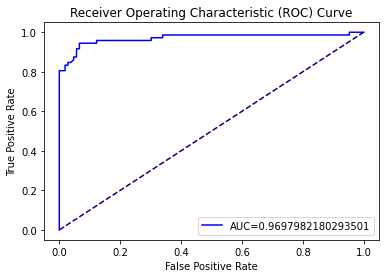

In [10]:
from baselayer_azure_ml import ESMLPipelineFactory
label = "Survived"

#rmse, r2, mean_abs_percent_error,accuracy,plt = ESMLPipelineFactory(p).get_test_scoring_4_regression(label)
auc,accuracy,f1, precision,recall,matrix, plt = ESMLPipelineFactory(p).get_test_scoring_7_classification(label)

print("AUC:")
print(auc)
print()
print("Accuracy:")
print(accuracy)
print()
print("F1 Score:")
print(f1)
print()
print("Precision:")
print(precision)
print()
print("Recall:")
print(recall)
print()
print("Confusion Matrix:")
print(matrix)


## 2b) ESML Scoring compare `1-codeline`: Promote model or not? If better, then `Register model`
- `IF` newly trained model in `current` environment (`DEV`, `TEST` or `PROD`) scores BETTER than existing model in `target` environment, then `new model` can be registered and promoted.

In [11]:
from baselayer_azure_ml import AutoMLFactory
target_env = p.dev_test_prod #"dev", test, prod  = Target environment. Does Model A score better than Model B?
print("Example: If new model scores better in DEV, we can promote this to TEST")

promote, m1_name, r1_id, m2_name, r2_run_id = AutoMLFactory(p).compare_scoring_current_vs_new_model(target_env)

print("Promote model?  {}".format(promote))
print("New Model: {} in environment {}".format(m1_name, p.dev_test_prod))
print("Existing Model: {} in environment {}".format(m2_name,target_env))

if (promote and p.dev_test_prod == target_env):# Can only register a model in same workspace (test->test) - need to retrain if going from dev->test
    AutoMLFactory(p).register_active_model(target_env)


Example: If new model scores better in DEV, we can promote this to TEST
Loading AutoML config settings from: dev
targe=source environement. Compare model version in DEV/TEST/PROD with latest registered in same DEV/TEST/PROD workspace (same workspace & subscriptiom comparison)
Package:azureml-automl-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-core, training version:1.30.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-defaults, training version:1.30.0, current version:1.26.0
Package:azureml-interpret, training version:1.30.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.26.0
Package:azureml-telemetry, tr

# 3) ESML `Deploy model ONLINE` in `2 lines of code` (AKS) 
- Deploy "offline" MODEL from old `run` in environment To →  `DEV`, `TEST` or `PROD` environment
- ESML saves `API_key in Azure keyvault automatically`
- ESML auto-config solves 4 common 'errors/things': `correct compute name` and `valid replicas, valid agents, valid auto scaling`
    - Tip: You can adjust the number of replicas, and different CPU/memory configuration, or using a different compute target.

inference_config, model, best_run = p.get_active_model_inference_config(p.ws) #  Get compute power & lib-dependecies for DOCKER...for correct (Dev,Test or Prod) environment.
service,api_uri, kv_aks_api_secret= p.deploy_automl_model_to_aks(model,inference_config,True) # Deploy: AKS dockerized with correct config (Dev,Test or Prod subscription & networking)

## 3b) DEPLOY TEST with ESML `2 lines of code`

X_test, y_test, tags = p.get_gold_validate_Xy() 
print(tags)
caller_id = "10965d9c-40ca-4e47-9723-5a608a32a0e4"

df = p.call_webservice(p.ws, X_test,caller_id) 
df.head()

# 3b) ESML `DEPLOY - custom scoring` file - predict proba

In [13]:
inference_config_to_override_and_inject, model, best_run = p.get_active_model_inference_config(p.ws) # 1) You can override this scoring_script - get a baseline, then modify...
my_custom_script_instead = 'scoring_file_dev_M01_titanic.py'
inference_config_to_override_and_inject.entry_script = 'c:\\Users\\jostrm\\OneDrive - Microsoft\\0_GIT\\2_My\\github\\azure-enterprise-scale-ml\\settings\\project_specific\\model\\dev_test_prod\\train\\automl\\' + my_custom_script_instead

inference_config_to_override_and_inject.entry_script # Verify path

Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Loading AutoML config settings from: dev
Loading AutoML config settings from: dev
Package:azureml-automl-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-core, training version:1.30.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-defaults, training version:1.30.0, current version:1.26.0
Package:azureml-interpret, training version:1.30.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.26.0
Package:azureml-telemetry, training ve

'c:\\Users\\jostrm\\OneDrive - Microsoft\\0_GIT\\2_My\\github\\azure-enterprise-scale-ml\\settings\\project_specific\\model\\dev_test_prod\\train\\automl\\scoring_file_dev_M01_titanic.py'

In [14]:
# DEPLOY with custom InferenceConfig (custom scoring script)
service,api_uri, kv_aks_api_secret= p.deploy_automl_model_to_aks(model,inference_config_to_override_and_inject, True) #2) (model,inference_config, overwrite_endpoint=True,deployment_config=None):

Deploying model: AutoML934d6699e0 with verison: 4 to environment: dev with overwrite_endpoint=True
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
image_build_compute = prj02-m01-dev
Found existing AksWebservice endpoint, deleting it, since overwrite=True
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster, esml-dev-prj02, using it.
Note: Autoscale_enabled=False, or since aks_dev_test=True in config, autoscaling is automatically shut off, e.g. overridden in config (since not supported) for environment dev
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-0

# INFERENCE - Scenario "Caller/Client"

## 1) Get MockData - Get some TEST-DATA via ESMLProject...the GoldTest

In [1]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLDataset, ESMLProject

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.inference_mode = False # We want "TRAIN" mode
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace

In [15]:
label = "Survived"
to_score = None
try:
    X_test = p.GoldTest.to_pandas_dataframe()
    to_score = X_test.drop([label], axis=1)
    #print(to_score.head()) # gold_test_1 = Dataset.get_by_name(ws, name=p.dataset_gold_test_name_azure)
except: 
    print ("you need to have splitted GOLD dataset, GoldTest need to exist. Change next cell from MARKDOWN, to CODE, and run that. Try this again... ")
# #X_test, y_test, tags = p.get_gold_validate_Xy() # Get the X_test data, ESML knows the SPLIT and LABEL already (due to training)

## 2) Call AKS Webservice in 3 ways (A,B,C)
- A) Also let AKS save data to lake
- B) Use the ESML helper method (fetched keys from vault AND joins result + features)
- C) Simulate "Rest only" - No ESML dependency 
    - No ESML meaning: Fetch keys by your own from vault + join/format JSON yourself + save data yourself to lake)

### Alt 1 - ESML.call_webservice, `get PANDAS joined` dataframe
#### `Also saves to LAKE, automatically`

In [16]:
#p.lakestore = p.set_lake_as_datastore(p.ws) # For AutoSave - this i NOT needed if p.init() is done...which usually is the case.
p.call_webservice(p.ws, to_score,"caller_id").head() # (X_test, firstRowOnly=True,pandas_result=True, api_uri=None,api_key="auto from keyvault")

Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Note: Fetching keys automatically via workspace keyvault.
Saving scoring to lake for project folder project002 and inference_model_version: 4 ...
...
..

Saved DATA to score successfully in LAKE, as file 'to_score_caller_id.parquet'
..
Saved SCORED data in LAKE, as file 'scored_caller_id.parquet'


,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,result,probability
0,3,Mr. Sahid Nakid,male,20.00,1,1,15.74,1,0.54
1,3,Mr. Hanna Assi Barah,male,20.00,0,0,7.23,0,0.38
2,3,Mr. Edward Willey,male,21.00,0,0,7.55,0,0.01
3,2,Master. Viljo Hamalainen,male,0.67,1,1,14.50,1,1.00
4,3,Mrs. Guillaume Joseph (Emma) de Messemaeker,female,36.00,1,0,17.40,1,0.83


### Alt 2 - use compute factory, control to `get JSON back` instead of PANDAS. 
#### `No saving to LAKE`

In [17]:
result, model_version_used = p.compute_factory.call_webservice(to_score,False,False) # (X_test, firstRowOnly=True,pandas_result=True, api_uri=None,api_key="auto from keyvault")
df_res = pd.read_json(result)
to_score.join(df_res) # Need to join the FEATURES yourself, post webservice call (simulate no ESML dependancy in caller)

Note: Fetching keys automatically via workspace keyvault.


,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,result,probability
0,3,Mr. Sahid Nakid,male,20.00,1,1,15.74,1,0.54
1,3,Mr. Hanna Assi Barah,male,20.00,0,0,7.23,0,0.38
2,3,Mr. Edward Willey,male,21.00,0,0,7.55,0,0.01
3,2,Master. Viljo Hamalainen,male,0.67,1,1,14.50,1,1.00
4,3,Mrs. Guillaume Joseph (Emma) de Messemaeker,female,36.00,1,0,17.40,1,0.83
...,...,...,...,...,...,...,...,...,...
173,3,Mr. Albert Johan Moss,male,29.00,0,0,7.78,0,0.48
174,2,Mrs. (Elizabeth Anne Maidment) Mellinger,female,41.00,0,1,19.50,1,0.98
175,2,Mr. John William Gill,male,24.00,0,0,13.00,0,0.12
176,1,Mr. Mark Fortune,male,64.00,1,4,263.00,0,0.06


### Alt 3 - Simulate client witn no ESML SDK, just using the "scoring endpoint". 
- Just JSON result (No ESML dependancy `get JSON back`)
#### `No saving to LAKE` and `no JOIN` 

In [18]:
from baselayer_azure_ml import ComputeFactory
import json
keyvault = p.ws.get_default_keyvault() # Authentica to your Azure ML workspace (ws)
api_uri = keyvault.get_secret(name='esml-dev-p02-m01-api') # titanic = m01
api_key = keyvault.get_secret(name='esml-dev-p02-m01-apisecret') #

result_json = ComputeFactory.call_webservice_static(to_score, api_uri,api_key,firstRowOnly=False) # Simulate "REST call" (no ESML dependancy, just a wrapper for a pytnon REST call)
res_dict = json.loads(result_json.text) # json -> dictionary
df_res = pd.read_json(res_dict) # dictionary -> pandas
all_result = X_test.join(df_res) # features + result
all_result

Relying on you having the keys...


,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,result,probability
0,1,3,Mr. Sahid Nakid,male,20.00,1,1,15.74,1,0.54
1,1,3,Mr. Hanna Assi Barah,male,20.00,0,0,7.23,0,0.38
2,0,3,Mr. Edward Willey,male,21.00,0,0,7.55,0,0.01
3,1,2,Master. Viljo Hamalainen,male,0.67,1,1,14.50,1,1.00
4,1,3,Mrs. Guillaume Joseph (Emma) de Messemaeker,female,36.00,1,0,17.40,1,0.83
...,...,...,...,...,...,...,...,...,...,...
173,1,3,Mr. Albert Johan Moss,male,29.00,0,0,7.78,0,0.48
174,1,2,Mrs. (Elizabeth Anne Maidment) Mellinger,female,41.00,0,1,19.50,1,0.98
175,0,2,Mr. John William Gill,male,24.00,0,0,13.00,0,0.12
176,0,1,Mr. Mark Fortune,male,64.00,1,4,263.00,0,0.06


In [23]:
# And....you need to save the data yourself to the lake, at this location
to_score_folder, scored_folder, date_folder = p.get_gold_scored_unique_path()
print("Save your data here, if you want to have ADF WriteBack function")
print()
print(scored_folder)
print()
print("Note: Last folder, UUID folder, should represent a 'unique scoring' for a day, but can be injected. Example: if we want a customerGUID instead ")

Save your data here, if you want to have ADF WriteBack function

projects/project002/01_titanic_model_clas/inference/1/scored/dev/2021_06_16/36673e6d7d17407fadb838237aa2e151/

Note: Last folder, UUID folder, should represent a 'unique scoring' for a day, but can be injected. Example: if we want a customerGUID instead 


# END

# EXTRA - more about `AutoLake Paths`

In [1]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLDataset, ESMLProject
p = ESMLProject() 
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace

In [22]:
p.inference_mode = True # This flag will "change the paths", from TRAIN folder to INFERENCE folder-structure

print("")
print("INFERENCE")
print("")

for d in p.Datasets:
    print(d.Name)
    print("IN", d.InPath)
    print("Bronze", d.BronzePath)
    print("Silver", d.SilverPath)

to_score_folder, scored_folder, date_folder = p.get_gold_scored_unique_path(p.date_scoring_folder)
print("Gold", to_score_folder, "  ...uuid folder, is to be able to have multiple unique scorings, same datetime")

print("")
print("TRAIN")
print("")

p.inference_mode = False # This flag will "change the paths"

for d in p.Datasets:
    print(d.Name)
    print("IN", d.InPath)
    print("Bronze", d.BronzePath)
    print("Silver", d.SilverPath)

print("Gold", p.GoldPath)


INFERENCE

ds01_titanic
IN projects/project002/01_titanic_model_clas/inference/1/ds01_titanic/in/dev/2021/01/01/
Bronze projects/project002/01_titanic_model_clas/inference/1/ds01_titanic/out/bronze/dev/
Silver projects/project002/01_titanic_model_clas/inference/1/ds01_titanic/out/silver/dev/
Gold projects/project002/01_titanic_model_clas/inference/1/gold/dev/2021_01_01/ecfa7236a44f469898ab1c84f431183c/   ...uuid folder, is to be able to have multiple unique scorings, same datetime

TRAIN

ds01_titanic
IN projects/project002/01_titanic_model_clas/train/ds01_titanic/in/dev/2021/01/01/
Bronze projects/project002/01_titanic_model_clas/train/ds01_titanic/out/bronze/dev/
Silver projects/project002/01_titanic_model_clas/train/ds01_titanic/out/silver/dev/
Gold projects/project002/01_titanic_model_clas/train/gold/dev/
